C:\Users\jllca\AppData\Local\Temp\ipykernel_14696\1253317925.py:14: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  iponan_2016 = pd.read_excel('iponan_2016.xlsx', index_col=0, date_parser=parser)# parse_dates=[0]


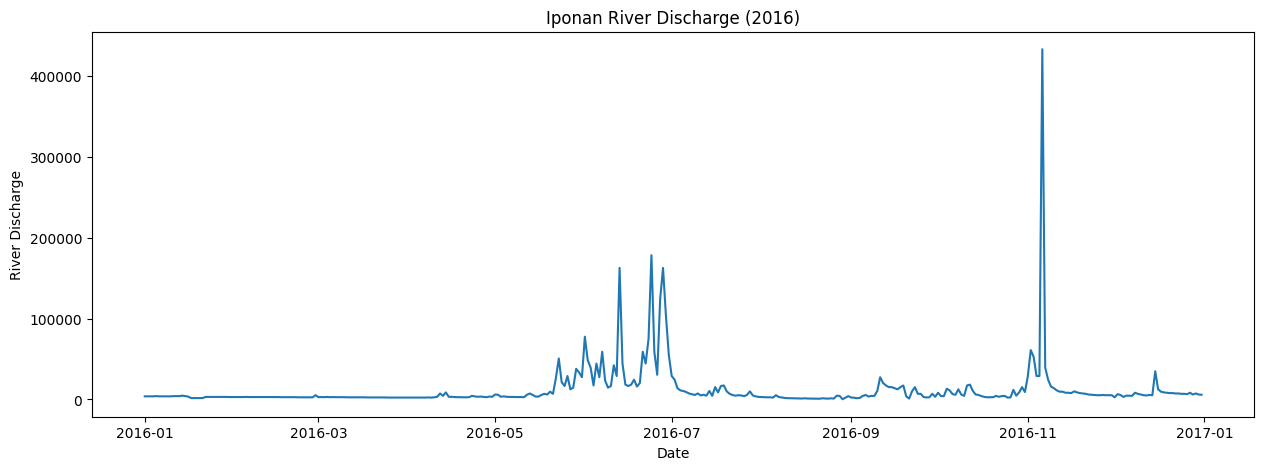

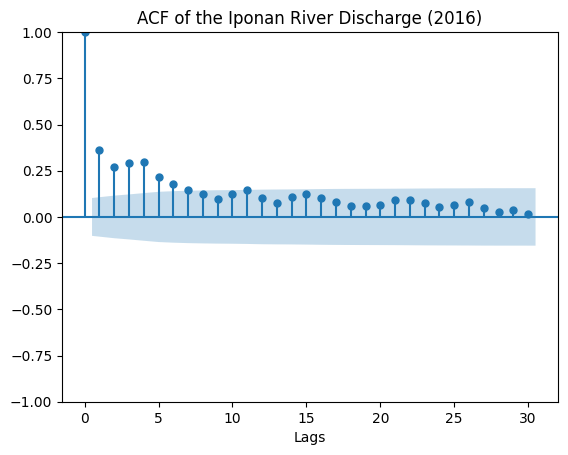

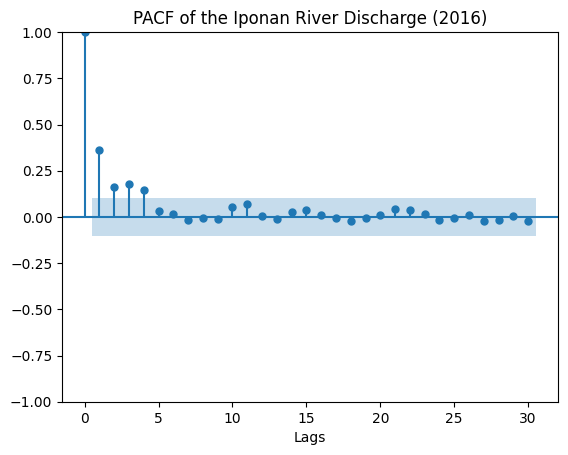

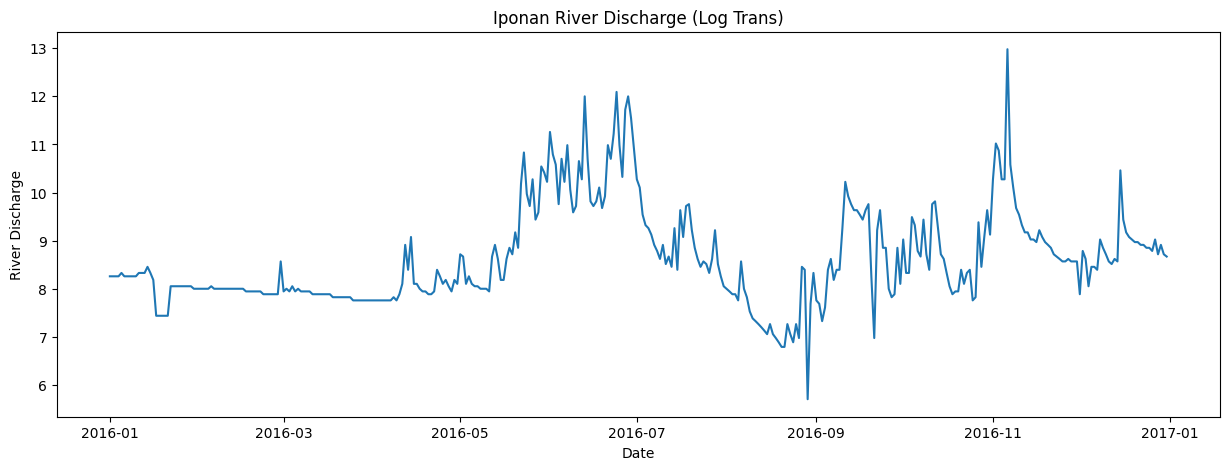

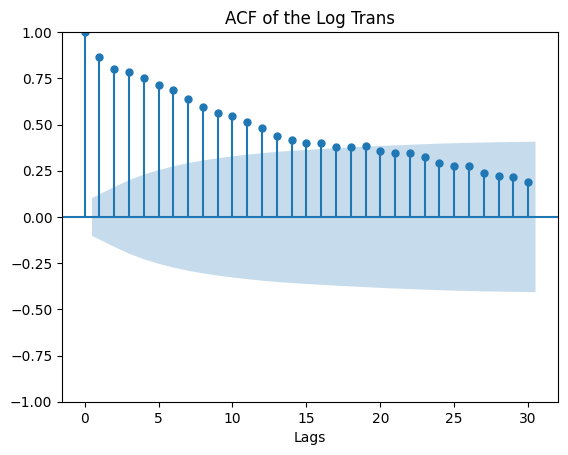

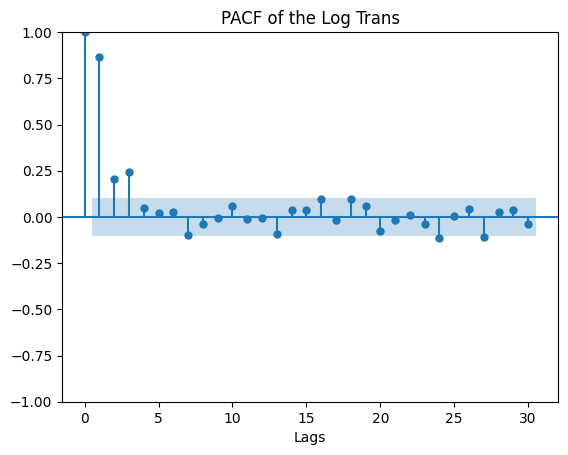

p-value: 0.03
The p-value: "0.03" < 0.05.The data is STATIONARY.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, timedelta
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error

def parser(s):
    return datetime.strptime(s,'%Y-%m-%d')
# READS THE DATA
iponan_2016 = pd.read_excel('iponan_2016.xlsx', index_col=0, date_parser=parser)# parse_dates=[0]

# INFER THE FREQUENCY OF THE DATA
iponan_2016 = iponan_2016.asfreq(pd.infer_freq(iponan_2016.index))

# TIME PLOT
plt.figure(figsize=(15,5))
plt.plot(iponan_2016)
plt.title('Iponan River Discharge (2016)')
plt.xlabel('Date')
plt.ylabel('River Discharge')
plt.show()

# ACF
plot_acf(iponan_2016, title='ACF of the Iponan River Discharge (2016)', lags=30)
plt.xlabel('Lags')
plt.show()

# ACF
plot_pacf(iponan_2016, title='PACF of the Iponan River Discharge (2016)', lags=30)
plt.xlabel('Lags')
plt.show()

# Log transformation
log_trans = np.log(iponan_2016['River Discharge'])

plt.figure(figsize=(15,5))
plt.plot(log_trans)
plt.title('Iponan River Discharge (Log Trans)')
plt.xlabel('Date')
plt.ylabel('River Discharge')
plt.show()

# ACF
plot_acf(log_trans, title='ACF of the Log Trans', lags=30)
plt.xlabel('Lags')
plt.show()

# PACF
plot_pacf(log_trans, title='PACF of the Log Trans', lags=30)
plt.xlabel('Lags')
plt.show()

# ADF TEST
adf_result = adfuller(log_trans)
adf_pvalue = round(adf_result[1],2)

print(f'p-value: {adf_pvalue}')
if adf_pvalue < 0.05:
    print(f'The p-value: "{adf_pvalue}" < 0.05.The data is STATIONARY.')
else:
    print(f'The p-value: "{adf_pvalue}" >= 0.05. The data is still NOT STATIONARY')

                               SARIMAX Results                                
Dep. Variable:        River Discharge   No. Observations:                  366
Model:               SARIMAX(3, 0, 1)   Log Likelihood                -261.474
Date:                Mon, 22 Dec 2025   AIC                            532.948
Time:                        18:49:24   BIC                            552.461
Sample:                    01-01-2016   HQIC                           540.702
                         - 12-31-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9682      0.145      6.688      0.000       0.684       1.252
ar.L2         -0.1630      0.111     -1.475      0.140      -0.380       0.054
ar.L3          0.1943      0.056      3.490      0.0

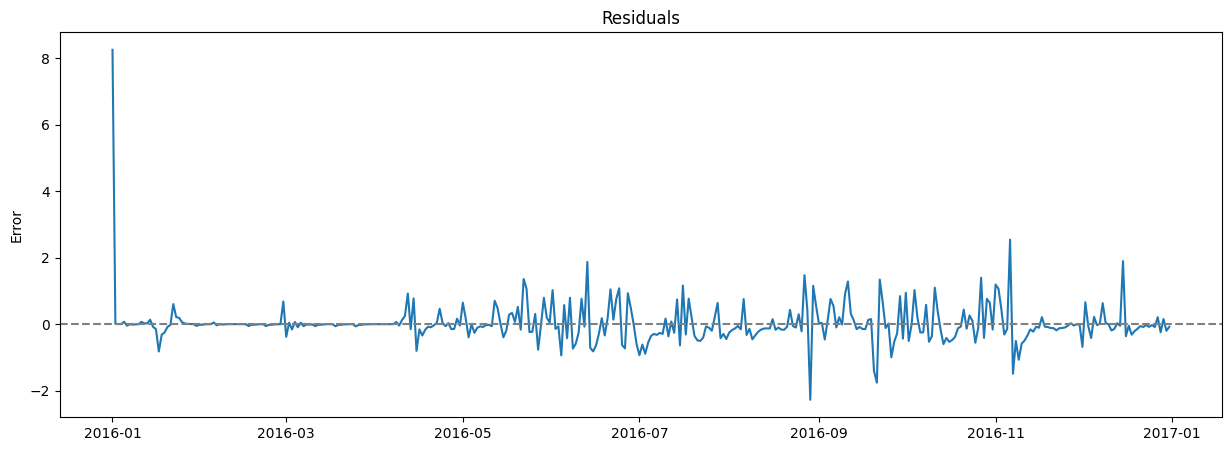

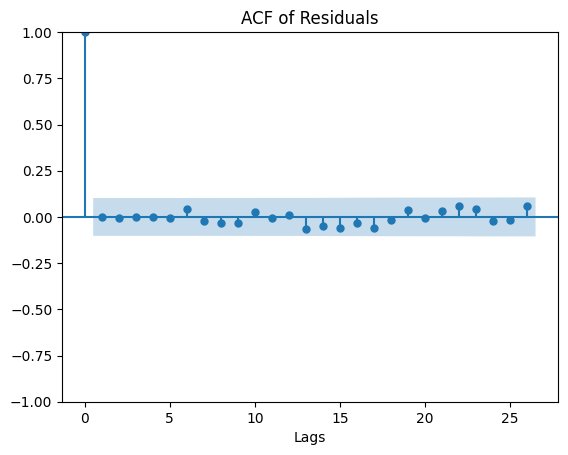

p-value: 1.0
P-value > 0.05. The residuals behave like white noise. Thus, the model is likely ADEQUATE.
MAPE: 3.81 %
RMSE: 0.56


In [13]:
# TRAINING AND TESTTING SETS
train_end = datetime(2016,9,30) 
test_end = datetime(2016,12,31) 

train_data = log_trans[: train_end] # JANUARY TO SEPTEMBER
test_data = log_trans[train_end + timedelta(days=1) : test_end] # OCTOBER TO DECEMBER

## ARMA(4,1) or ARMA(1,1)

# FITTING ARMA MODEL
order=(3,0,1)
seasonal_order=(0,0,0,0)

model = SARIMAX(log_trans, order=order, seasonal_order=seasonal_order)

model_fit = model.fit()

print(model_fit.summary())

residuals = model_fit.resid

plt.figure(figsize=(15,5))
plt.plot(residuals)
plt.title('Residuals')
plt.ylabel('Error')
plt.axhline(0, linestyle='--', color='gray')
plt.show()

#  RESIDUALS ACF
plot_acf(residuals, title='ACF of Residuals')
plt.xlabel('Lags')
plt.show()

# LJUNG BOX TEST
lb_result = acorr_ljungbox(residuals, lags=[10], return_df=True)
lb_pvalue = round(lb_result['lb_pvalue'].item(),2)
print(f'p-value: {lb_pvalue}')

if lb_pvalue > 0.05:
    print('P-value > 0.05. The residuals behave like white noise. Thus, the model is likely ADEQUATE.')
else:
    print('P-value <= 0.05. The residuals do not behave like white noise. Thus, the model is likely INADEQUATE.')

arma_model = model_fit.apply(log_trans)
pred_arma = arma_model.get_prediction(start=test_data.index[0], end=test_data.index[-1], dynamic=False)
pred_arma_mean = pred_arma.predicted_mean

rmse = round(np.sqrt(mean_squared_error(test_data, pred_arma_mean)), 2)
mape = round(mean_absolute_percentage_error(test_data, pred_arma_mean)*100, 2)
print(f'MAPE: {mape} %')
print(f'RMSE: {rmse}')

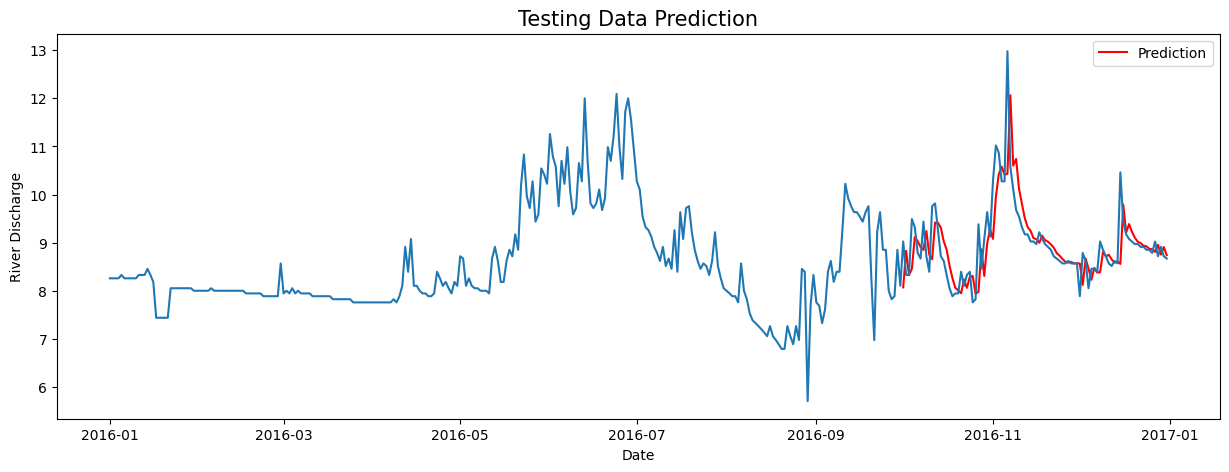

2017-01-01    4999.014684
2017-01-02    4599.263553
2017-01-03    4278.128847
2017-01-04    3943.793116
2017-01-05    3631.827188
2017-01-06    3348.292187
2017-01-07    3087.167930
Freq: D, Name: predicted_mean, dtype: float64


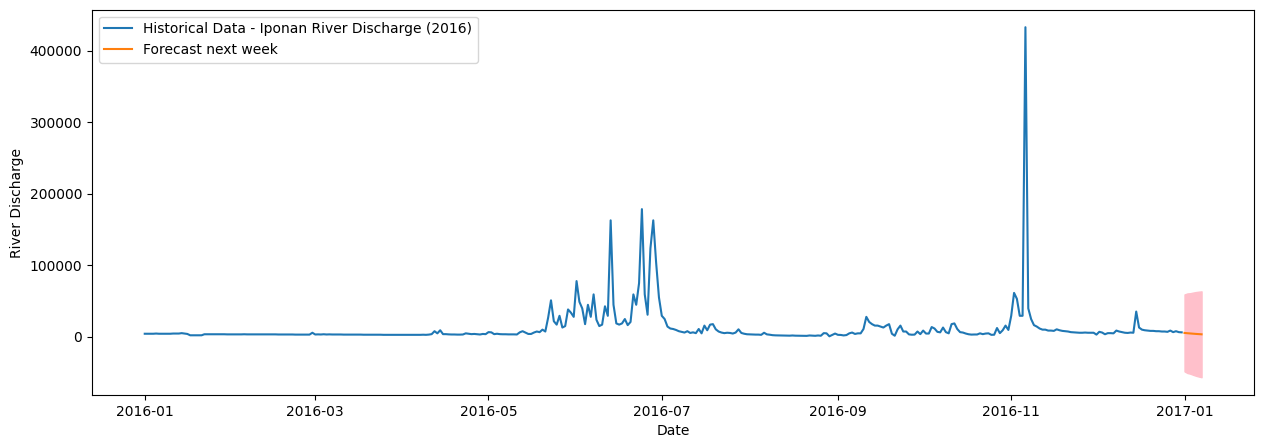

In [10]:
# Plots Testing Data Prediction 
plt.figure(figsize=(15,5))

plt.plot(pred_arma_mean, label='Prediction', color='red')
plt.plot(log_trans)
plt.legend()

plt.title('Testing Data Prediction', fontsize=15)
plt.ylabel('River Discharge')
plt.xlabel('Date')
plt.show()

# FITTING THE ARMA TO THE ENTIRE DATASET
final_model = SARIMAX(iponan_2016, order=order, seasonal_order=seasonal_order)

final_model_fit = final_model.fit()

forecast_result = final_model_fit.get_forecast(steps=7)
forecast_mean = forecast_result.predicted_mean
forecast_ci = forecast_result.conf_int(alpha=0.05)
print(forecast_mean)

plt.figure(figsize=(15,5))
plt.plot(iponan_2016, label='Historical Data - Iponan River Discharge (2016)')
plt.plot(forecast_mean, label='Forecast next week')
plt.legend()

plt.fill_between(forecast_ci.index,
                 forecast_ci.iloc[:,0],
                 forecast_ci.iloc[:, 1],
                 color='pink',
                 label='95% Prediction Interva'
)
plt.xlabel('Date')
plt.ylabel('River Discharge')
plt.show()